In [19]:
import os
import sys
import json
import datasets
import numpy as np
import pandas as pd
from dotenv import dotenv_values
from pathlib import Path
from scipy.special import softmax
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

config = dotenv_values("./../../../config/.env") # take environment variables from .env.
BASE_PATH = Path(config["BASE_PATH"])

sys.path.insert(1, str(BASE_PATH/"code"))
from ZeDiAc.definitions import LABELCONFIG, MODELCONFIG

mm = 25.4
textwidth = 149/mm

# plt.rcParams.keys()
aspect =  1.618
width = textwidth*0.9
height = width / aspect
matplotlib.rcParams.update({
    "font.family": 'sans',  # use serif/main font for text elements
    "font.size": 7,
    "text.usetex": False,   # use inline math for ticks
    "pgf.rcfonts": False,   # don't setup fonts from rc parameters
    "pgf.texsystem" : "lualatex",
    "figure.figsize": [width, height]})
cmap = matplotlib.cm.tab10
colors = [cmap(i) for i in range(cmap.N)]
from textwrap import wrap


with open(BASE_PATH/"config"/"config.json", "r") as f:
    config = json.load(f)
paths = {
    "base": BASE_PATH,
    "data": BASE_PATH/"data",
    "10k": BASE_PATH/"data"/"10k",
    "stoxx": BASE_PATH/"data"/"stoxx",
    "writing": BASE_PATH/"writing"/"MSc-Thesis-Emerging-Risks",
    "tables": BASE_PATH/"writing"/"MSc-Thesis-Emerging-Risks"/"tables",
    "figures": BASE_PATH/"writing"/"MSc-Thesis-Emerging-Risks"/"figures"/"plots"
}

In [2]:
df_u = datasets.load_from_disk(paths["data"]/"processed"/"unexpected"/"zero-shot").to_pandas()
df_l = datasets.load_from_disk(paths["data"]/"processed"/"loss"/"zero-shot").to_pandas()

In [3]:
df = df_l.merge(df_u.drop(columns=["text", "n_words", "filing_type"]), on=["report_id", "paragraph_nr"])

## PCA

In [17]:
model_cols = {}
template_cols = {}
target_cols = {}
label_cols = {}
all_cols = []
for template, t_key in LABELCONFIG["templates"].items():
    template_cols[t_key] = []
for model in ["RoBERTa", "DeBERTa"]:
    model_cols[model] = []
for target, label_dict in LABELCONFIG["labels"].items():
    if target in ["loss", "unexpected"]:
        target_cols[target] = []
        for label, l_key in label_dict.items():
            label_cols[l_key] = []
###
for model in ["RoBERTa", "DeBERTa"]:
    for template, t_key in LABELCONFIG["templates"].items():
        for target, label_dict in LABELCONFIG["labels"].items():
            if target in ["loss", "unexpected"]:
                for label, l_key in label_dict.items():
                    col_name = f"{MODELCONFIG[model]['abbrev']}_{t_key}_{l_key}"
                    model_cols[model].append(f"p_{col_name}")
                    template_cols[t_key].append(f"p_{col_name}")
                    target_cols[target].append(f"p_{col_name}")
                    label_cols[l_key].append(f"p_{col_name}")
                    all_cols.append(f"p_{col_name}")
                    id_entail = MODELCONFIG[model]["label2id"]["entailment"]
                    df[f"p_{col_name}"] = softmax(np.array(df[f"logits_{col_name}"].to_list()), axis=1)[:, id_entail]

In [13]:
pca = PCA(n_components=5)

def print_pca(df, col_dict):
    pca.fit(np.array(df[[col for slice, cols in col_dict.items() for col in cols]]))
    print("Variance explained by first 5 pc's:", round(sum(pca.explained_variance_ratio_[:5])*100,1), "%")
    x = np.arange(pca.components_.shape[1])
    width = 0.2
    fig, ax = plt.subplots(layout='constrained')
    for i in range(5):
        plt.bar(x+(i*width), pca.components_[i,:], width=0.4)
    plt.legend(["PC1", "PC2", "PC3", "PC4", "PC5"], loc="lower right")

    slice_indices = [0]
    for slice_nr in [len(cols) for slice, cols in col_dict.items()]:
        slice_indices.append(slice_indices[-1] + slice_nr)

    for i, slice_name in enumerate([slice for slice, cols in col_dict.items()]):
        plt.annotate(slice_name, xy=(slice_indices[i] + (slice_indices[i+1]-slice_indices[i])/2, 0.4), ha="center")
    plt.vlines(x=slice_indices, ymin=-0.45, ymax=0.6, colors="black", linestyles="dashed", linewidth=0.5)

Variance explained by first 5 pc's: 73.2 %


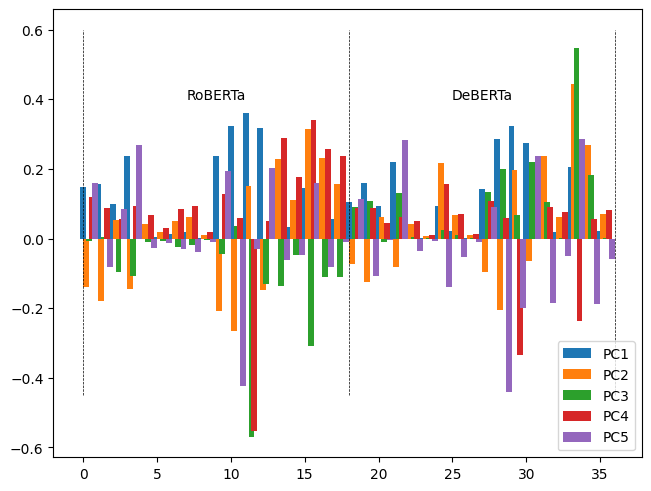

In [13]:
print_pca(df, col_dict=model_cols)
plt.savefig(paths["figures"]/"pca"/"models.pgf", bbox_inches="tight")

Variance explained by first 5 pc's: 73.2 %


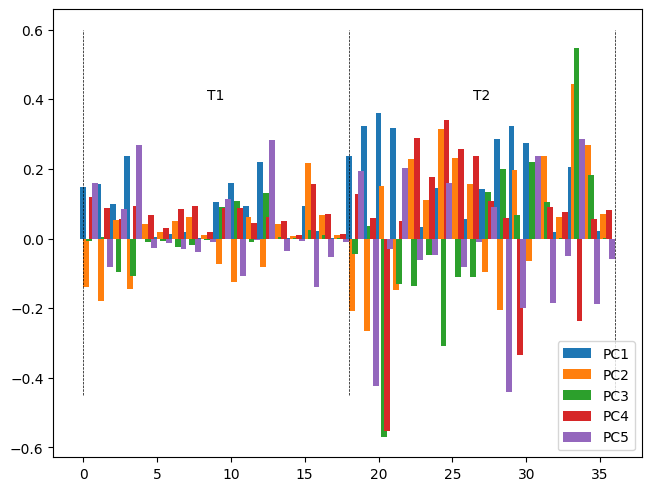

In [14]:
print_pca(df, col_dict=template_cols)
plt.savefig(paths["figures"]/"pca"/"templates.pgf", bbox_inches="tight")

Variance explained by first 5 pc's: 73.2 %


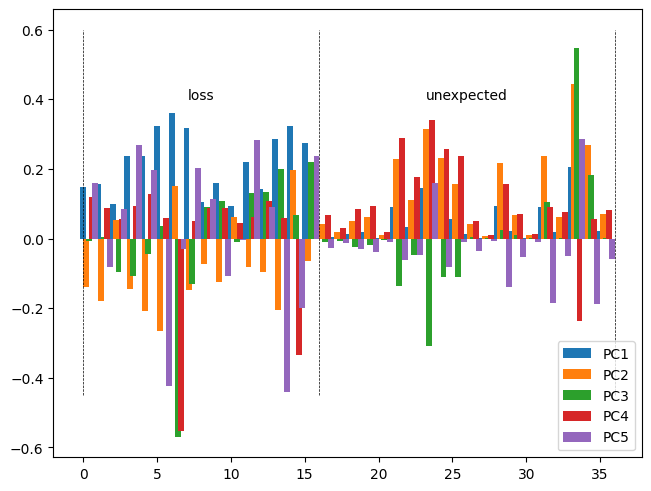

In [15]:
print_pca(df, col_dict=target_cols)
plt.savefig(paths["figures"]/"pca"/"targets.pgf", bbox_inches="tight")

Variance explained by first 5 pc's: 73.2 %


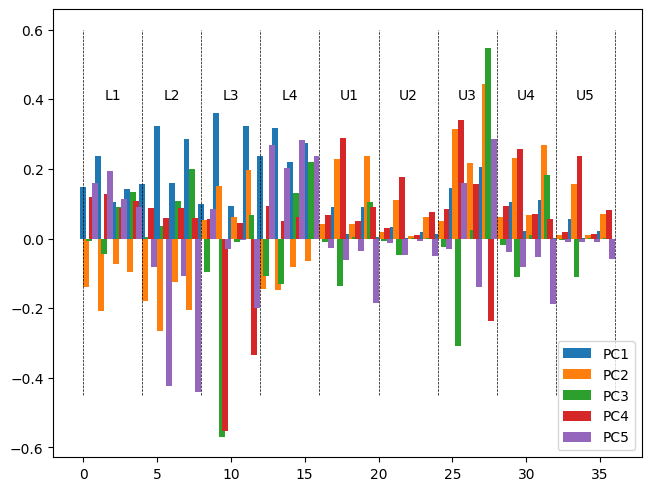

In [16]:
print_pca(df, col_dict=label_cols)
plt.savefig(paths["figures"]/"pca"/"labels.pgf", bbox_inches="tight")

## Correlation

In [10]:
from scipy.spatial.distance import jaccard
def compute_jacc_of_lists(l1, l2):
    l1 = np.array(l1)
    l2 = np.array(l2)
    l1[l1 > 0.5] = 1
    l1[l1 <= 0.5] = 0
    l2[l2 > 0.5] = 1 
    l2[l2 <= 0.5] = 0
    return [jaccard(l1[i], l2[i]) for i in range(len(l1))]

def compute_corr_of_lists(data, slice1, slice2):
    mat = np.zeros(len(slice1), len(slice2))
    for i, slice1 in enumerate(data[slice1]):
        for j, slice2 in enumerate(data[slice2]):
            mat[i,j] = np.corrcoef(slice1, slice2)[0,1]
    return np.matrix(mat)

def jaccard_matrix(data):
    mat = np.zeros((len(data), len(data)))
    for i, slice1 in enumerate(data):
        for j, slice2 in enumerate(data):
            l1 = np.array(slice1)
            l2 = np.array(slice2)
            l1[l1 > 0.5] = 1
            l1[l1 <= 0.5] = 0
            l2[l2 > 0.5] = 1
            l2[l2 <= 0.5] = 0
            mat[i,j] = jaccard(l1, l2)
    return mat

def compute_corr_of_lists(l1, l2):
    return [np.corrcoef(l1[i], l2[i])[0,1] for i in range(len(l1))]

def plot_similarity(df, col_dict, metric, aggregation, subset_dict=None):
    data = []
    x_axis = []
    y_axis = []
    if aggregation == "mean":
        for slice, cols in col_dict.items():
            data.append(df[cols].mean(axis=1).to_numpy())
            x_axis.append(slice)
            y_axis.append(slice)
        fig, ax = plt.subplots()
        if metric == "correlation":
            mat = np.corrcoef(data)
            im = ax.imshow(mat, cmap="hot_r", vmin=0, vmax=1)
        elif metric == "jaccard":
            mat = jaccard_matrix(data)
            im = ax.imshow(mat, cmap="hot", vmin=0, vmax=1)
        ax.set_xticks(np.arange(len(x_axis)), x_axis, rotation=45)
        ax.set_yticks(np.arange(len(y_axis)), y_axis)
        ax.set_title(f"{metric} similarity of average of predictions")
        plt.colorbar(im)
        fig.tight_layout()
    elif aggregation == "none":
        fig, ax = plt.subplots(len(col_dict.keys()), len(col_dict.keys()))
        for i, slice1 in enumerate(col_dict.keys()):
            for j, slice2 in enumerate(col_dict.keys()):
                l1 =  [df[col].to_numpy() for col in col_dict[slice1]]
                l2 =  [df[col].to_numpy() for col in col_dict[slice2]]
                if metric == "correlation":
                    res = compute_corr_of_lists(l1, l2)
                elif metric == "jaccard":
                    res = compute_jacc_of_lists(l1, l2)
                ax[i, j].hist(res)
                ax[i, j].set_xlim(0,1)
                ax[i, j].text(0.5, ax[i,j].get_ylim()[1]*0.8, '{:0.3f} \n ({:0.3f})'.format(np.mean(res), np.std(res)), ha='center', va='center')
                ax[i, j].set_title(f"{slice1} vs {slice2}")
        fig.tight_layout()
    elif aggregation == "subset":
        fig, ax = plt.subplots(len(col_dict.keys()), len(col_dict.keys()))
        for i, slice1 in enumerate(col_dict.keys()):
            for j, slice2 in enumerate(col_dict.keys()):
                data = []
                x_axis = []
                y_axis = []
                for subset, subset_cols in subset_dict.items():
                    cols = [col for col in subset_cols if col in col_dict[slice1] or col in col_dict[slice2]] 
                    data.append(df[cols].mean(axis=1).to_numpy())
                    x_axis.append(subset)
                    y_axis.append(subset)
                if metric == "correlation":
                    mat = np.corrcoef(data)
                    im = ax[i, j].imshow(mat, cmap="hot_r", vmin=0, vmax=1)
                elif metric == "jaccard":
                    mat = jaccard_matrix(data)
                    im = ax[i, j].imshow(mat, cmap="hot", vmin=0, vmax=1)
                ax[i, j].set_xticks(np.arange(len(x_axis)), x_axis, rotation=45)
                ax[i, j].set_yticks(np.arange(len(y_axis)), y_axis)
                ax[i, j].set_title(f"{slice1} vs {slice2}")
        plt.colorbar(im)
        fig.tight_layout()

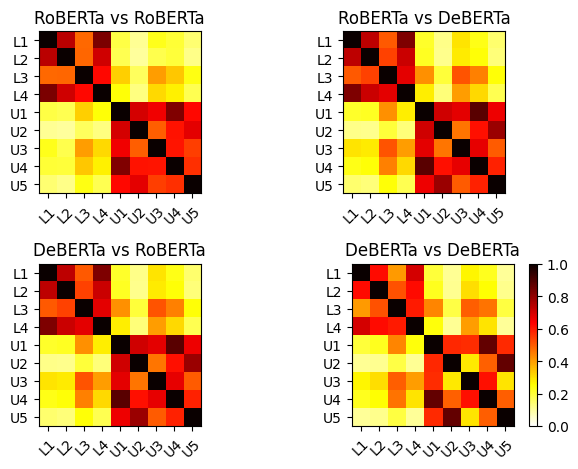

In [18]:
plot_similarity(df, col_dict=model_cols, metric="correlation", aggregation="subset", subset_dict=label_cols)
plt.savefig(paths["figures"]/"similarity"/"models_labels.pgf", bbox_inches="tight")

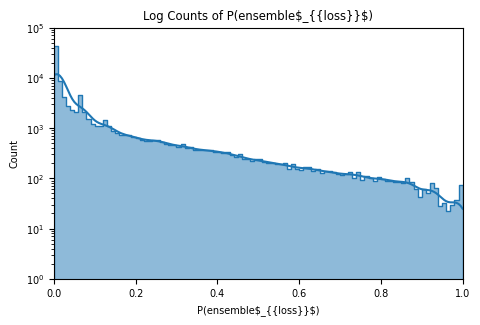

In [43]:
fig, ax = plt.subplots()
g = sns.histplot(
    df[target_cols["loss"]].mean(axis=1),
    element="step",
    stat="count",
    kde=True,
    log_scale=(False, True),
    bins=100,
    ax=ax
)
ax.set_xlim(0, 1)
ax.set_ylim(1, 100_000)
ax.set_xlabel("P(ensemble\$_{{loss}}\$)")
plt.title("Log Counts of P(ensemble\$_{{loss}}\$)")
plt.savefig(paths["figures"]/"density_p_loss_zero-shot_hist.pgf", bbox_inches="tight")
plt.savefig(paths["figures"]/"density_p_loss_zero-shot_hist.png", bbox_inches="tight")

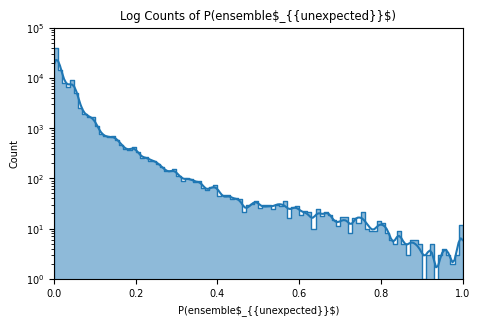

In [42]:
fig, ax = plt.subplots()
g = sns.histplot(
    df[target_cols["unexpected"]].mean(axis=1),
    element="step",
    stat="count",
    kde=True,
    log_scale=(False, True),
    bins=100,
    ax=ax
)
ax.set_xlim(0, 1)
ax.set_ylim(1, 100_000)
ax.set_xlabel("P(ensemble\$_{{unexpected}}\$)")
plt.title("Log Counts of P(ensemble\$_{{unexpected}}\$)")
plt.savefig(paths["figures"]/"density_p_unexpected_zero-shot_hist.pgf", bbox_inches="tight")
plt.savefig(paths["figures"]/"density_p_unexpected_zero-shot_hist.png", bbox_inches="tight")

/tmp/ipykernel_479200/849706889.py:69: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


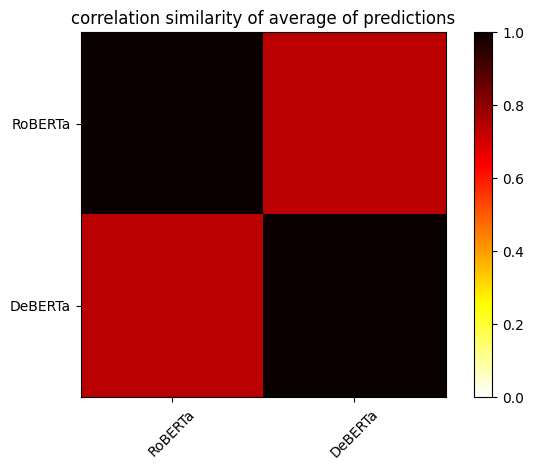

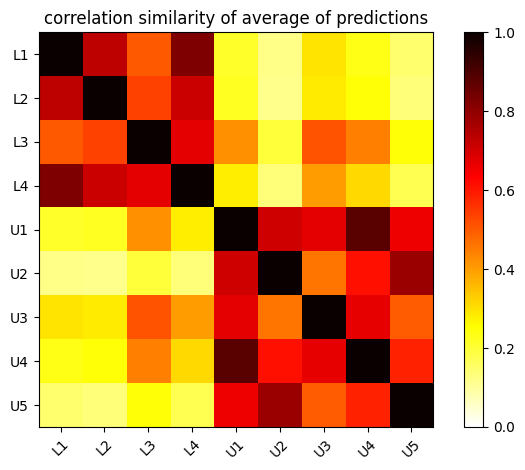

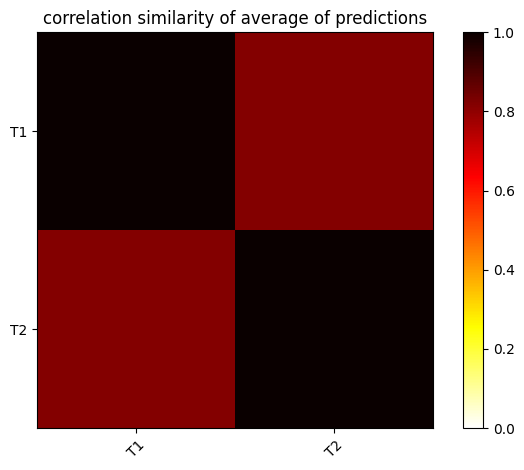

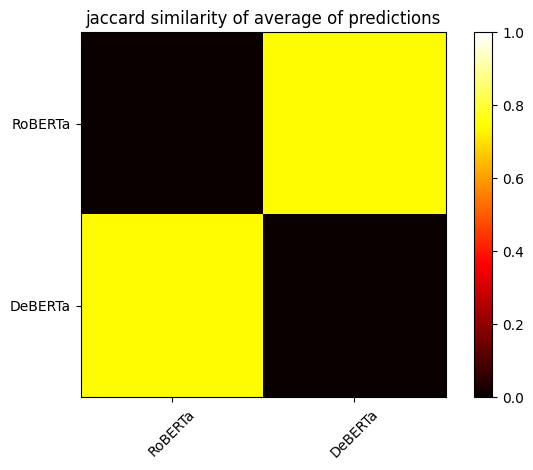

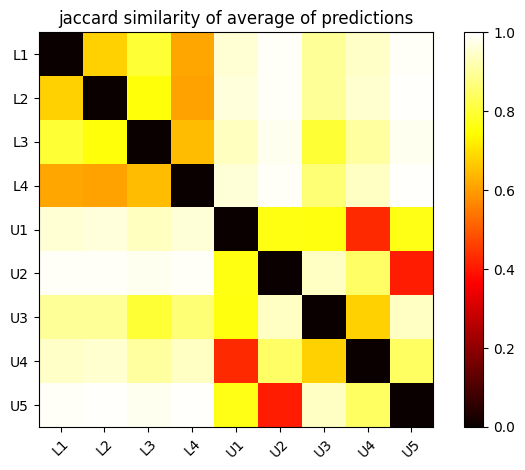

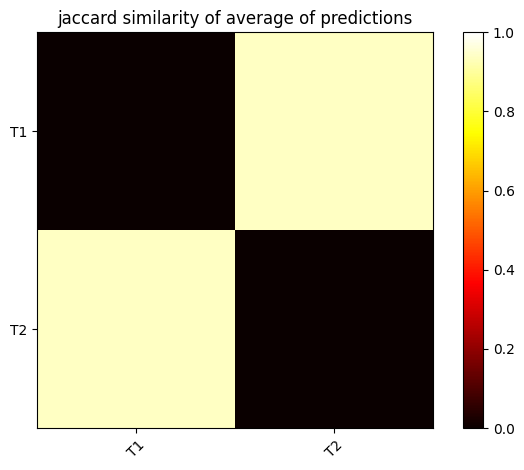

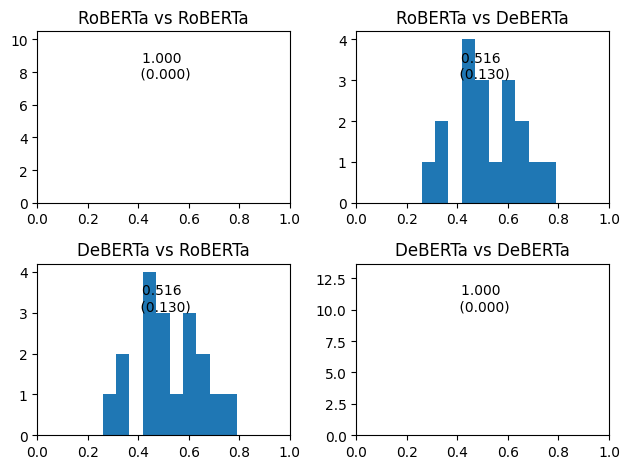

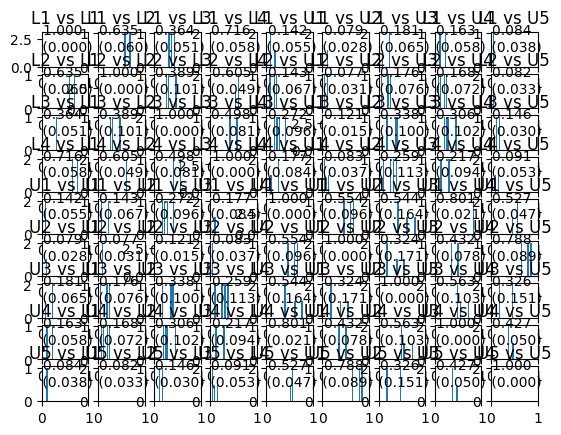

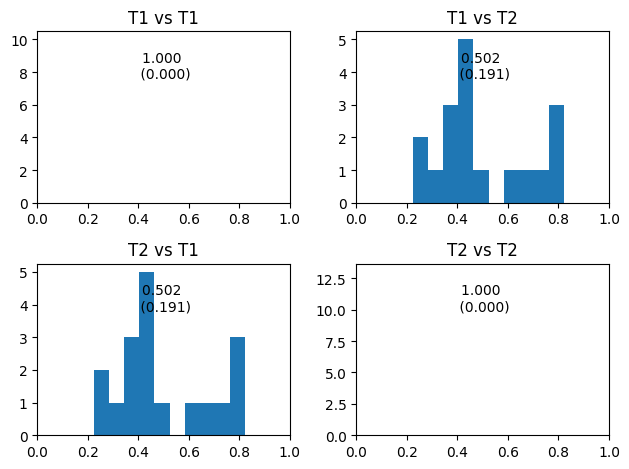

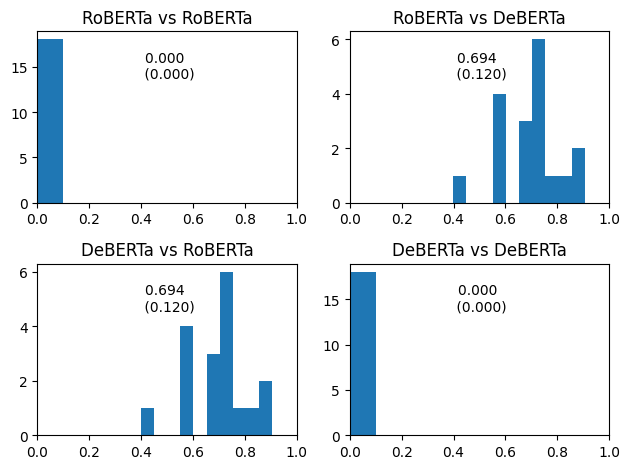

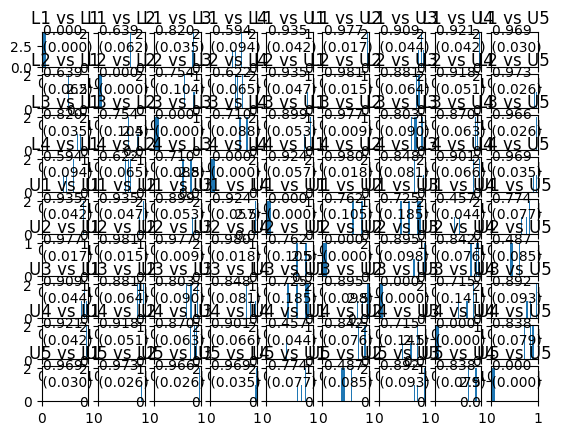

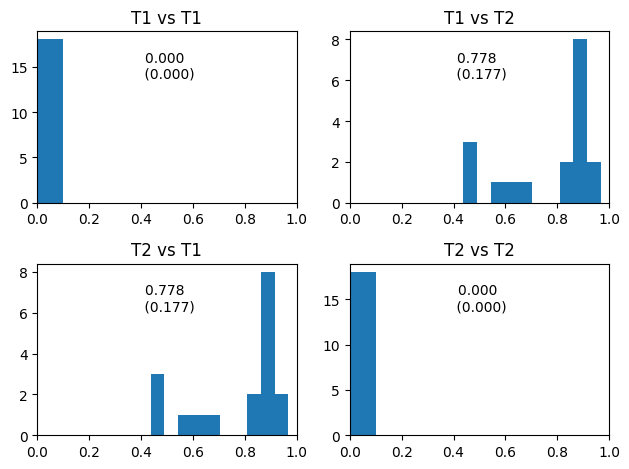

In [201]:
for aggregation in ["mean", "none"]:
    for metric in ["correlation", "jaccard"]:
        for col_dict in [model_cols, label_cols, template_cols]:
            plot_similarity(df, col_dict=col_dict, metric=metric, aggregation=aggregation)